Import relevant source's and datasets (downloaded the english names). 

Interestingly when uploading only 0's the RMSE is ~1.2. Thus we know that most of the predicted value's should be equal to zero and there should not be too big of values predicted (hence capping the predictions). 

In [93]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from itertools import product

In [72]:
items = pd.read_csv("items_eng.csv")
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
items_categories = pd.read_csv("categories_eng.csv")
shops = pd.read_csv("shops_eng.csv")

Let's have a look at the data

In [73]:
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


In [74]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [75]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Save the ID's for uploading the file

In [76]:
ID = test['ID']
ID

0              0
1              1
2              2
3              3
4              4
           ...  
214195    214195
214196    214196
214197    214197
214198    214198
214199    214199
Name: ID, Length: 214200, dtype: int64

When taking a closer look the at the item categories it shows the first word is a group. We are interested in that so let's substract that and create a new variab

In [77]:
pd.DataFrame(items_categories.category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Headsets / Headphones,Accessories - PS2,Accessories - PS3,Accessories - PS4
1,Accessories - PSP,Accessories - PSVita,Accessories - XBOX 360,Accessories - XBOX ONE
2,Tickets (Digital),Delivery of goods,Game consoles - PS2,Game consoles - PS3
3,Game consoles - PS4,Game consoles - PSP,Game consoles - PSVita,Game consoles - XBOX 360
4,Game consoles - XBOX ONE,Game consoles - Others,Games - PS2,Games - PS3
5,Games - PS4,Games - PSP,Games - PSVita,Games - XBOX 360
6,Games - XBOX ONE,Games - Game accessories,Android games - Number,MAC Games - Number
7,PC Games - Additional Editions,PC Games - Collector's Editions,PC Games - Standard Editions,PC Games - Digital
8,"Payment Cards (Cinema, Music, Games)",Payment Cards - Live!,Payment Cards - Live! (Digital),Payment cards - PSN
9,Payment cards - Windows (Digital),Cinema - Blu-Ray,Cinema - Blu-Ray 3D,Cinema - Blu-Ray 4K


In [78]:
items_categories['group_name'] = items_categories['category_name'].str.extract(r'(^[\w\s]*)')
items_categories.head()

,category_name,category_id,group_name
0,PC - Headsets / Headphones,0,PC
1,Accessories - PS2,1,Accessories
2,Accessories - PS3,2,Accessories
3,Accessories - PS4,3,Accessories
4,Accessories - PSP,4,Accessories


When looking at the shop name's it shows that some store a twice in the data. Let's manually change that in both train and test

In [ ]:
pd.DataFrame(shops.shop_name.values.reshape(-1, 4))

train.loc[train.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
train.loc[train.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
train.loc[train.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
train.loc[train.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

When looking at the shop's name it shows it has the city of the shop in it. We substract the city and manually change the one's that went wrong. 

In [80]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!'] = 'yakutsk'
shops.loc[shops.city == 'st.'] = 'stpetersburg'
shops.loc[shops.city == 'n.novgorod'] = 'novgorod'

pd.DataFrame(shops.city.values.reshape(-1, 4))

,0,1,2,3
0,yakutsk,yakutsk,adygea,balashikha
1,volga,vologda,voronezh,voronezh
2,voronezh,outbound,zhukovsky,zhukovsky
3,internet-shop,kazan,kazan,kaluga
4,kolomna,krasnoyarsk,krasnoyarsk,kursk
5,"moscow""",moscow,moscow,moscow
6,moscow,moscow,moscow,moscow
7,moscow,moscow,moscow,moscow
8,moscow,mytishchi,novgorod,novgorod
9,novosibirsk,novosibirsk,omsk,rostovnadonu


It shows that there a some very large outliers. Let's remove those. 

<AxesSubplot:>

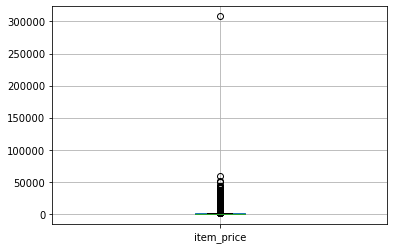

In [81]:
train.boxplot(column=['item_price'])

<AxesSubplot:>

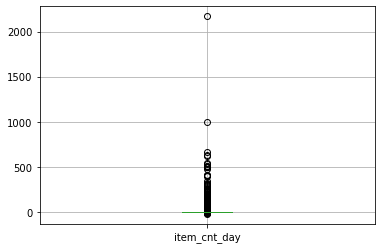

In [82]:
train.boxplot(column=['item_cnt_day'])

In [83]:
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]

In [84]:

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Using the loop from the class to add the 0's

In [85]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

test['date_block_num'] = 34
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,ID
0,59,22154,0,1.0,0.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


Now let's add as much data as possible. We calculate a lot a means and sums by different groups. Also the first item a item was sold (seems interesting). 

In [86]:
#Combine sets
df = pd.merge(df, items, on=['item_id'], how='left')
df = pd.merge(df, items_categories, on=['category_id'], how='left')
df = pd.merge(df, shops, on=['shop_id'], how='left')
#Combine sets
train = pd.merge(train, items, on=['item_id'], how='left')
train = pd.merge(train, items_categories, on=['category_id'], how='left')
train = pd.merge(train, shops, on=['shop_id'], how='left')
train = train.drop(["item_name", "category_name", "shop_name"], axis=1)
#Only keep the shops in the test set 
df = df[df['shop_id'].isin(test.shop_id.unique())]
#Add price
group = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index()
df = pd.merge(df, group, on=['shop_id', 'item_id', 'date_block_num'], how='left')
#Mean encoding& sum by some
group = df.groupby(['item_id', 'date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_item"}, errors="raise")
df = pd.merge(df, group, on=['item_id', 'date_block_num'], how='left')
group = df.groupby(['item_id', 'date_block_num'])['item_cnt_month'].sum().reset_index().rename(columns={"item_cnt_month": "sum_encoding_item"}, errors="raise")
df = pd.merge(df, group, on=['item_id', 'date_block_num'], how='left')
group = df.groupby(['shop_id','date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_shop"}, errors="raise")
df = pd.merge(df, group, on=['shop_id', 'date_block_num'], how='left')
group = df.groupby(['shop_id','date_block_num'])['item_cnt_month'].sum().reset_index().rename(columns={"item_cnt_month": "sum_encoding_shop"}, errors="raise")
df = pd.merge(df, group, on=['shop_id', 'date_block_num'], how='left')
group = df.groupby(['city','date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_city"}, errors="raise")
df = pd.merge(df, group, on=['city', 'date_block_num'], how='left')
group = df.groupby(['category_id','date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_category"}, errors="raise")
df = pd.merge(df, group, on=['category_id', 'date_block_num'], how='left')
group = df.groupby(['group_name','date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_groep"}, errors="raise")
df = pd.merge(df, group, on=['group_name', 'date_block_num'], how='left')
group = df.groupby(['date_block_num'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "mean_encoding_block"}, errors="raise")
df = pd.merge(df, group, on=['date_block_num'], how='left')
group = df.groupby(['date_block_num'])['item_cnt_month'].sum().reset_index().rename(columns={"item_cnt_month": "sum_encoding_block"}, errors="raise")
df = pd.merge(df, group, on=['date_block_num'], how='left')
#Calculate revenue by shop and item
df['revenue'] = df['item_cnt_month'] * df['item_price']
#Total revenue by shop
group = df.groupby(['shop_id', 'date_block_num'])['revenue'].sum().reset_index().rename(columns={"revenue": "sum_shop_revenue"}, errors="raise")
df = pd.merge(df, group, on=['shop_id', 'date_block_num'], how='left')
#Total sales by city
group = df.groupby(['city','item_id', 'date_block_num'])['item_cnt_month'].sum().reset_index().rename(columns={"item_cnt_month": "sum_city_sales"}, errors="raise")
df = pd.merge(df, group, on=['city','item_id', 'date_block_num'], how='left')
#First time sold in store and overall
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index().rename(columns={"date_block_num": "month_release"}, errors="raise")
first_shop_block = df.groupby(['item_id', 'shop_id'])['date_block_num'].min().reset_index().rename(columns={"date_block_num": "shop_release"}, errors="raise")
df = pd.merge(df, first_item_block, on=['item_id'], how='left')
df = pd.merge(df, first_shop_block, on=['item_id', 'shop_id'], how='left')
#Mean and maximim price by city
citymean = train.groupby(['city', 'item_id', 'date_block_num'])['item_price'].mean().reset_index().rename(columns={"item_price": "city_mean"}, errors="raise")
citymin = train.groupby(['city', 'item_id', 'date_block_num'])['item_price'].min().reset_index().rename(columns={"item_price": "city_min"}, errors="raise")
df = pd.merge(df, citymean, on=['city', 'item_id', 'date_block_num'], how='left')
df = pd.merge(df, citymin, on=['city', 'item_id', 'date_block_num'], how='left')

In [87]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

Lets add lag's. We need the first leg because a price are not available for the test set. We also add t-1, t-2,t-3,t-6,t-12 to show differences over time. We drop the value's not needed. 

In [88]:
#Add the lags
df = lag_feature(df, [1, 2, 3, 6, 12], 'item_cnt_month')
df = lag_feature(df, [1, 2, 3, 6, 12], 'item_price')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_item')
df = lag_feature(df, [1, 2, 3, 6, 12], 'sum_encoding_item')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_shop')
df = lag_feature(df, [1, 2, 3, 6, 12], 'sum_encoding_shop')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_city')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_category')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_groep')
df = lag_feature(df, [1, 2, 3, 6, 12], 'mean_encoding_block')
df = lag_feature(df, [1, 2, 3, 6, 12], 'sum_encoding_block')
df = lag_feature(df, [1, 2, 3, 6, 12], 'sum_shop_revenue')
df = lag_feature(df, [1, 2, 3, 6, 12], 'city_mean')
df = lag_feature(df, [1, 2, 3, 6, 12], 'city_min')
#Calculate differences in shop price over time
df['item_price_dif_12'] = df['item_price_lag_1'] - df['item_price_lag_2']
df['item_price_dif_13'] = df['item_price_lag_1'] - df['item_price_lag_3']
df['item_price_dif_16'] = df['item_price_lag_1'] - df['item_price_lag_6']
df['item_price_dif_112'] = df['item_price_lag_1'] - df['item_price_lag_12']
#Calculate differences in shop sales over time
df['mean_encoding_item_dif_12'] = df['mean_encoding_item_lag_1'] - df['mean_encoding_item_lag_2']
df['mean_encoding_item_dif_13'] = df['mean_encoding_item_lag_1'] - df['mean_encoding_item_lag_3']
df['mean_encoding_item_dif_16'] = df['mean_encoding_item_lag_1'] - df['mean_encoding_item_lag_6']
df['mean_encoding_item_dif_112'] = df['mean_encoding_item_lag_1'] - df['mean_encoding_item_lag_12']
df['mean_encoding_shop_dif_12'] = df['mean_encoding_shop_lag_1'] - df['mean_encoding_shop_lag_2']
df['mean_encoding_shop_dif_13'] = df['mean_encoding_shop_lag_1'] - df['mean_encoding_shop_lag_3']
df['mean_encoding_shop_dif_16'] = df['mean_encoding_shop_lag_1'] - df['mean_encoding_shop_lag_6']
df['mean_encoding_shop_dif_112'] = df['mean_encoding_shop_lag_1'] - df['mean_encoding_shop_lag_12']
df['mean_encoding_city_dif_12'] = df['mean_encoding_city_lag_1'] - df['mean_encoding_city_lag_2']
df['mean_encoding_city_dif_13'] = df['mean_encoding_city_lag_1'] - df['mean_encoding_city_lag_3']
df['mean_encoding_city_dif_16'] = df['mean_encoding_city_lag_1'] - df['mean_encoding_city_lag_6']
df['mean_encoding_city_dif_112'] = df['mean_encoding_city_lag_1'] - df['mean_encoding_city_lag_12']
df['mean_encoding_category_dif_12'] = df['mean_encoding_category_lag_1'] - df['mean_encoding_category_lag_2']
df['mean_encoding_category_dif_13'] = df['mean_encoding_category_lag_1'] - df['mean_encoding_category_lag_3']
df['mean_encoding_category_dif_16'] = df['mean_encoding_category_lag_1'] - df['mean_encoding_category_lag_6']
df['mean_encoding_category_dif_112'] = df['mean_encoding_category_lag_1'] - df['mean_encoding_category_lag_12']
df['mean_encoding_groep_dif_12'] = df['mean_encoding_groep_lag_1'] - df['mean_encoding_groep_lag_2']
df['mean_encoding_groep_dif_13'] = df['mean_encoding_groep_lag_1'] - df['mean_encoding_groep_lag_3']
df['mean_encoding_groep_dif_16'] = df['mean_encoding_groep_lag_1'] - df['mean_encoding_groep_lag_6']
df['mean_encoding_groep_dif_112'] = df['mean_encoding_groep_lag_1'] - df['mean_encoding_groep_lag_12']
df['mean_encoding_block_dif_12'] = df['mean_encoding_block_lag_1'] - df['mean_encoding_block_lag_2']
df['mean_encoding_block_dif_13'] = df['mean_encoding_block_lag_1'] - df['mean_encoding_block_lag_3']
df['mean_encoding_block_dif_16'] = df['mean_encoding_block_lag_1'] - df['mean_encoding_block_lag_6']
df['mean_encoding_block_dif_112'] = df['mean_encoding_block_lag_1'] - df['mean_encoding_block_lag_12']
#Calculate price compared to city mean and city mean
df['item_price_dif_city_mean'] = df['item_price_lag_1'] - df['city_mean_lag_1']
df['item_price_dif_city_min'] = df['item_price_lag_1'] - df['city_min_lag_1']
#Sum of sales last Q
df['sum_encoding_block_Q'] = df['sum_encoding_block_lag_1'] + df['sum_encoding_block_lag_2'] + df['sum_encoding_block_lag_3']
df['sum_encoding_item_Q'] = df['sum_encoding_item_lag_1'] + df['sum_encoding_item_lag_2'] + df['sum_encoding_item_lag_3']
df['sum_encoding_shop_Q'] = df['sum_encoding_shop_lag_1'] + df['sum_encoding_shop_lag_2'] + df['sum_encoding_shop_lag_3']


In [89]:
df = df.drop(["item_price", "revenue", "sum_shop_revenue", "sum_city_sales", "city_mean", "city_min",
             'item_name', 'category_name', 'shop_name', 'mean_encoding_item','mean_encoding_shop','mean_encoding_city',
              'mean_encoding_category','mean_encoding_groep','sum_shop_revenue','city_mean','city_min','mean_encoding_block',
             'sum_encoding_item','sum_encoding_block', 'sum_encoding_shop'],  axis=1)

Change the data type of the non-numeric variable's and the split in train and test. We use the last 6 months to train the model on. 

In [91]:
for c in ['shop_id','group_name', 'city', 'category_id']:
    df[c] = df[c].astype('category')
X_train = df[df.date_block_num.isin([28,29,30,31,32,33])].drop(columns='ID')
Y_train = X_train['item_cnt_month']
del X_train['item_cnt_month']

X_test = df[df['date_block_num']==34].drop(columns=['item_cnt_month','ID'])
X_test = X_test.reset_index()

#Delete to empty space
del df

X_train.head()

,shop_id,item_id,date_block_num,category_id,group_name,city,month_release,shop_release,item_cnt_month_lag_1,item_cnt_month_lag_2,...,mean_encoding_groep_dif_112,mean_encoding_block_dif_12,mean_encoding_block_dif_13,mean_encoding_block_dif_16,mean_encoding_block_dif_112,item_price_dif_city_mean,item_price_dif_city_min,sum_encoding_block_Q,sum_encoding_item_Q,sum_encoding_shop_Q
7797112,19,15710,28,40,Cinema,kursk,3,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797113,19,15702,28,37,Cinema,kursk,0,0,0.0,0.0,...,0.046997,-0.01123,-0.019043,NaN,-0.010498,NaN,NaN,inf,34.0,4624.0
7797114,19,15698,28,37,Cinema,kursk,0,0,0.0,0.0,...,0.046997,-0.01123,-0.019043,-0.056641,-0.010498,NaN,NaN,inf,39.0,4624.0
7797115,19,16234,28,65,Gifts,kursk,3,3,1.0,3.0,...,-0.023926,-0.01123,-0.019043,-0.056641,-0.010498,0.0,0.0,inf,59.0,4624.0
7797116,19,15680,28,40,Cinema,kursk,27,27,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,NaN,NaN


Train a lightgbm model with CV. We use CV to evaluate to well the model does. 

In [94]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 2020,
    'verbose': 1
}

feature_name_indexes = ['shop_id','group_name', 'city', 'category_id']

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)


#evals_result = {}
bst  = lgb.cv(
        params, 
        lgb_train,
        num_boost_round=5000,
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=50, 
        early_stopping_rounds = 50)



C:\Users\Rogier\Anaconda\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_id', 'city', 'group_name', 'shop_id']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.434199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17480
[LightGBM] [Info] Number of data points in the train set: 1035168, number of used features: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.424045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17480
[LightGBM] [Info] Number of data points in the train set: 1035169, number of used features: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17480
[LightGBM] [Info] Number of data points in the train set: 1035169, number of used features: 111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.430401 seconds.
You c

Use the number of iterations found in the previous step. 

In [95]:
num_iteration=np.argmin(pd.DataFrame(bst['rmse-mean']))

bst  = lgb.train(params, lgb_train,num_boost_round=num_iteration, feature_name = feature_name,
        categorical_feature = feature_name_indexes)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.529641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17480
[LightGBM] [Info] Number of data points in the train set: 1293961, number of used features: 111
[LightGBM] [Info] Start training from score 0.264520


As stating in the begining we want to clip the data due to reletive well score with only zero's. 
Finally, write csv file. This results in 8/10 on coursera (accuracy ~0.97 & ~0.98)

In [96]:
Y_test = bst.predict(X_test[feature_name]).clip(0, 20)


In [97]:
submission = pd.DataFrame({
    "ID": ID, 
    "item_cnt_month": Y_test
})
submission.to_csv('lightgbm_submission.csv', index=False)